In [1]:
import sys
print(sys.executable)

/home/at3ee/anaconda3/envs/py39/bin/python


In [2]:
import arviz as az
import theano
import theano.tensor as tt
import pymc3 as pm


In [3]:
az.style.use("arviz-darkgrid")

In [32]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


## Dataset
The Eight Schools problem is a study of SAT coaching effects from eight schools [[1]](#References). For each the eight schools `num_schools` we have the estimated treatment effect (`treatment_effects`) and standard error of the effect estimate (`treatment_stddevs`).

In [5]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # estimated treatment effect
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE


Below is a boxplot of the data:

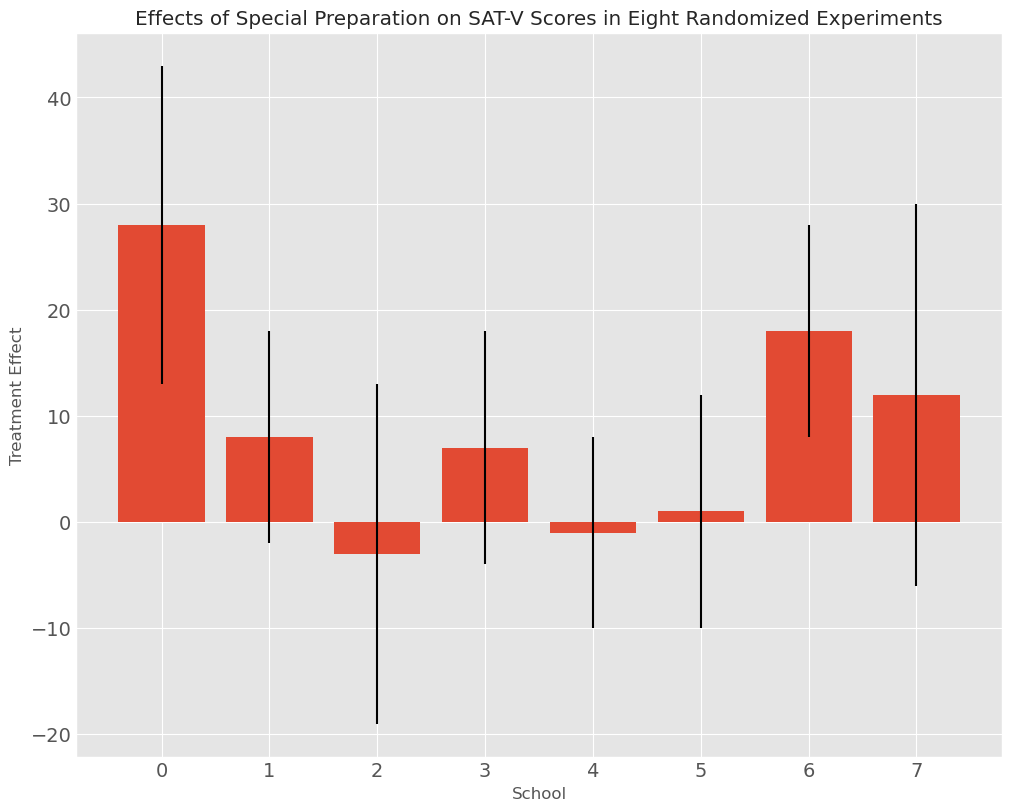

In [6]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("Effects of Special Preparation on SAT-V Scores in Eight Randomized Experiments")
plt.xlabel("School")
plt.ylabel("Treatment Effect")
fig.set_size_inches(10, 8)
plt.show()


## 1. Non-centered Parameterization
Let, ${\mathcal D}=\{x_{i}\}_{i=1}^{8}$ a set of observations, where each $x_i$ is a observed random variable (RV).
$$
x_i \sim \mathcal{N}\left(\theta_i, \sigma_i \right)
$$

Declare $\mathbf{\Theta} = \left\{ \theta_i \right\}_{i=1}^8 $ used ton calculate the probabilities of observed RVs. 

$$
\theta_i = \mu + \tau * \eta_i
$$

where, $\eta_i \sim \mathcal{N}(0, 1)$ and $\mathbf{\eta} = \{ \eta \}_{i=1}^8 $. Also $\mathbf{\phi} = \left\{\mu, \tau, \mathbf{\eta} \right\}$ parameterizing $\mathbf{\Theta}$. $\sigma_i \sim \textit{HalfCauchy}(\beta)$.

### 1.1. Variational inference


In [7]:
# Parameterization by MCMC
with pm.Model() as model:
    eta = pm.Normal("eta", 0, 1, shape=num_schools)
    mu = pm.Normal("mu", 0, sigma=10)
#     tau = pm.HalfNormal("tau", 10)
    tau = pm.HalfCauchy("tau", beta=1)
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=treatment_stddevs, observed=treatment_effects)

    trace_h = pm.sample(2000, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


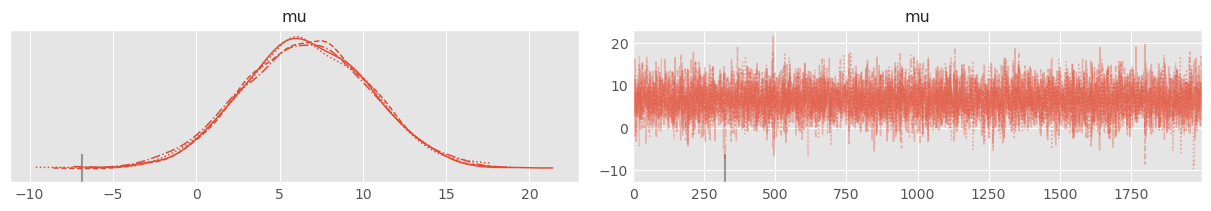

In [8]:
az.plot_trace(trace_h, var_names="mu");

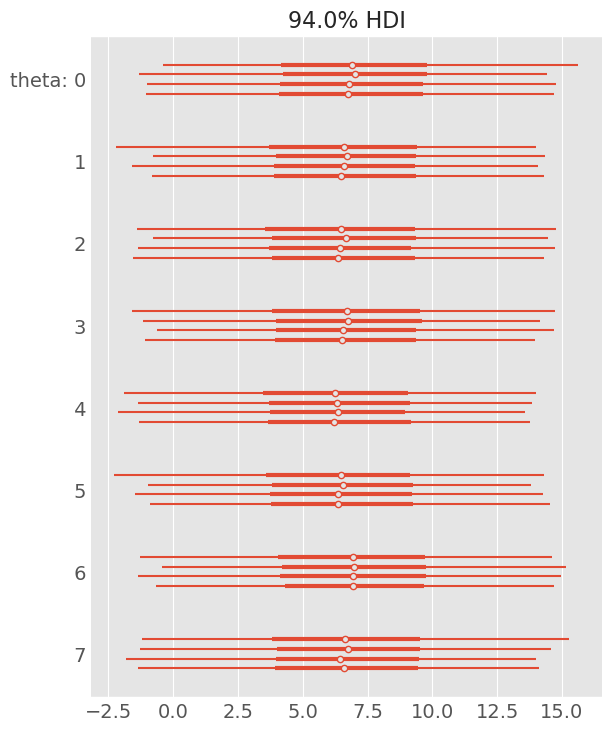

In [9]:
az.plot_forest(trace_h, var_names="theta");

### 1.2. ADVI Inference 


In [10]:
with model:
    mean_field = pm.fit(method="advi")

Finished [100%]: Average Loss = 31.991


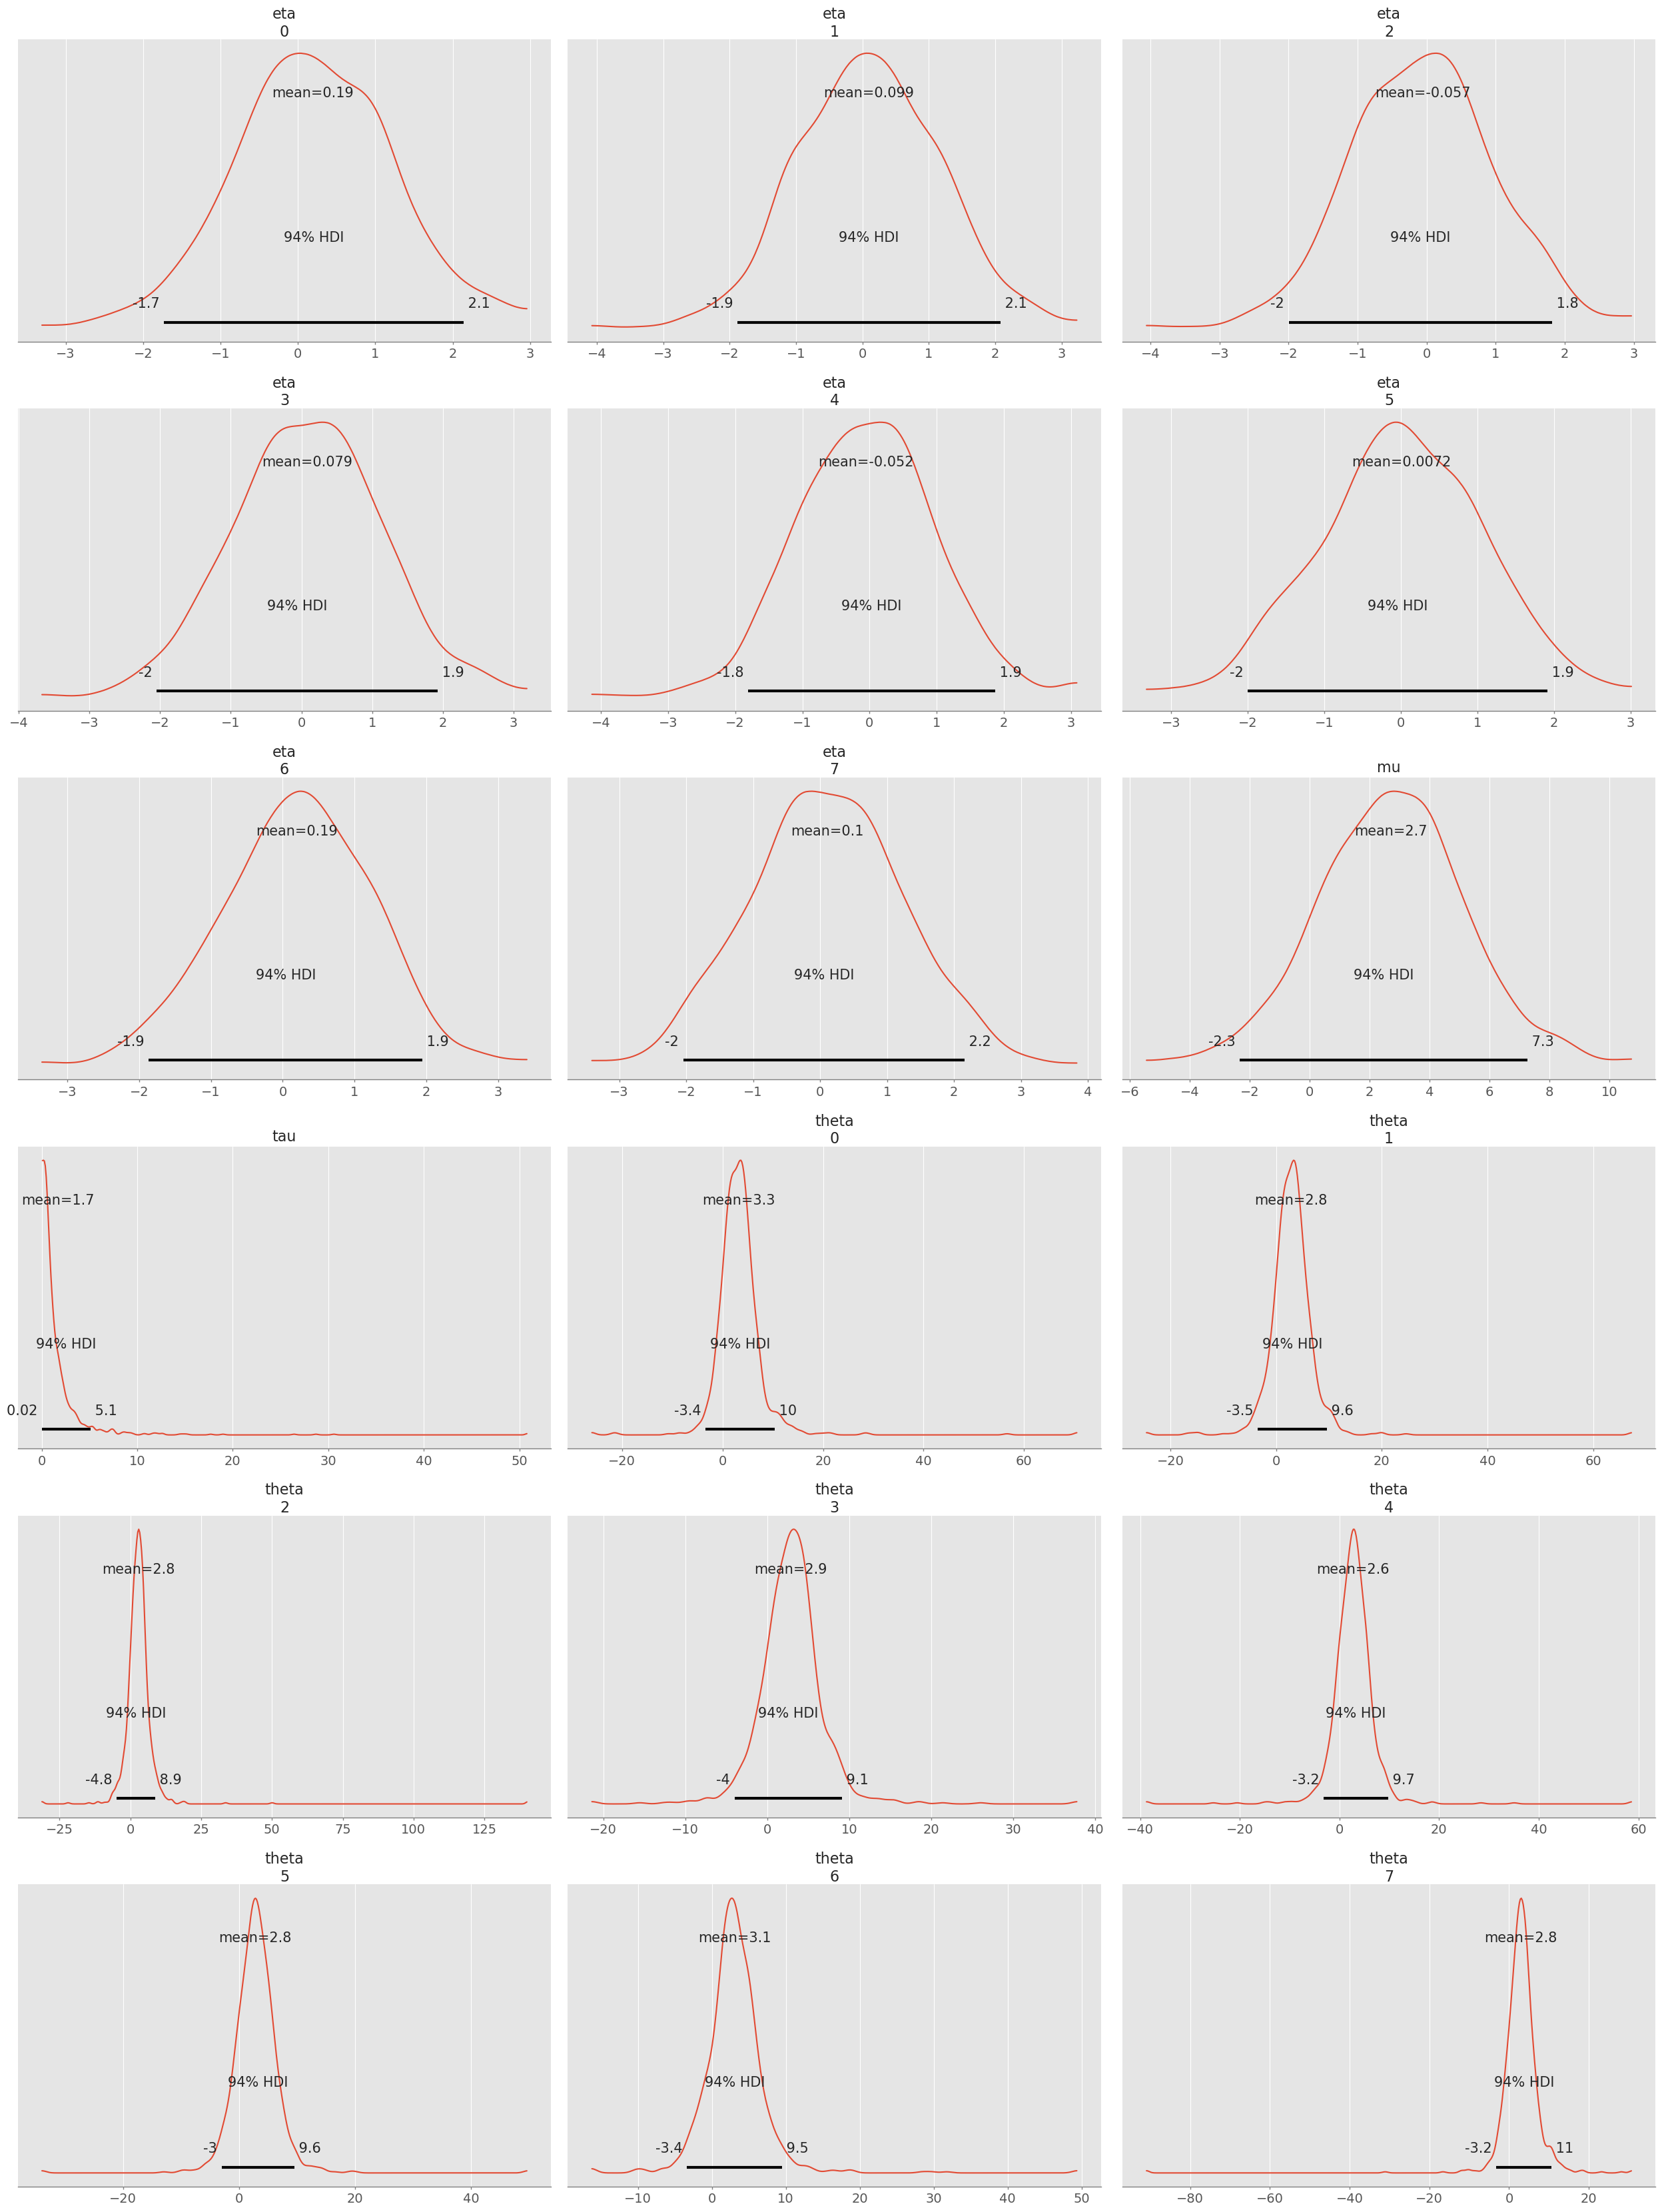

In [11]:
pm.plot_posterior(mean_field.sample(1000));

### 1.2. SVGD Inference

In [12]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )


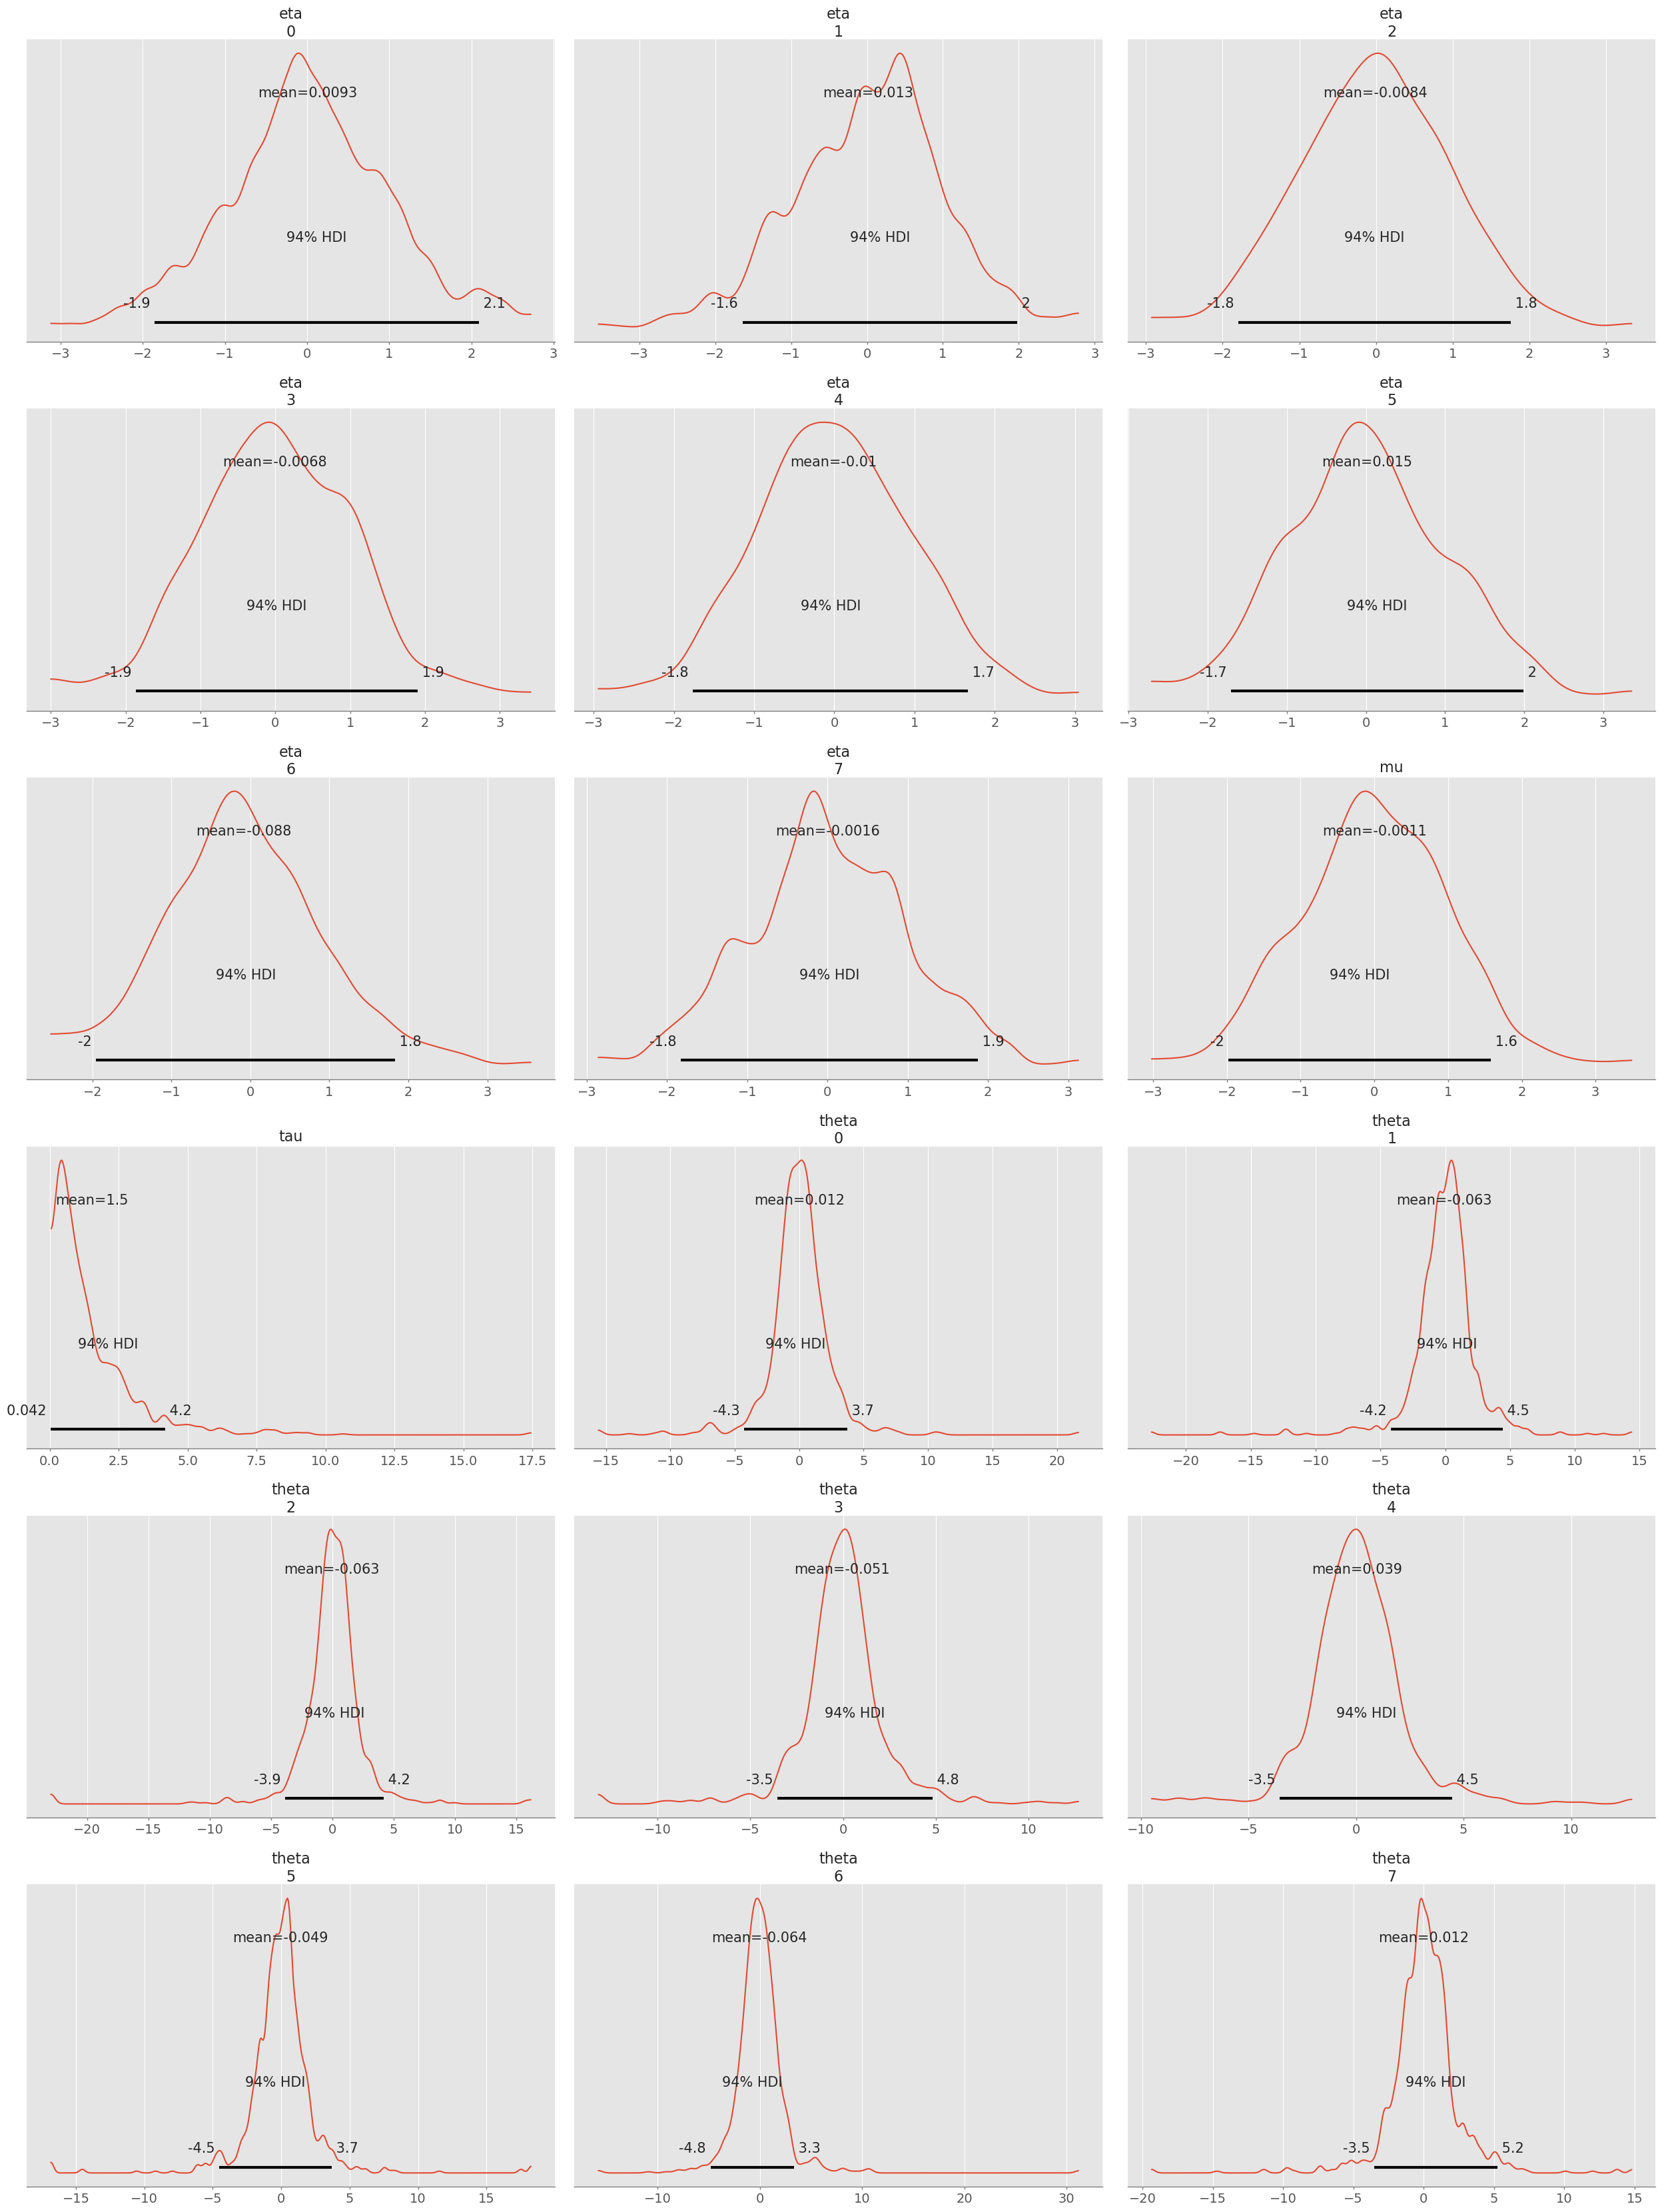

In [13]:
pm.plot_posterior(svgd_approx.sample(1000));

#### 1.2.2. $f$-divergence
Let ${\mathcal D}=\{x_{i}\}_{i=1}^{N}$ are $N$ observations.
The $f$-divergence between probability density functions, $q(\theta; \mathbf{\phi})$ and $p(\theta \vert \mathcal{D})$ is defined as [[3]](#References),
$$
D_f(q \parallel p) = \int_\theta f \left(\frac{q(\theta)}{p(\theta \vert \mathcal{D})}\right) p(\theta \vert \mathcal{D})d\theta = \mathbb{E}_p \left[f \left(\frac{q(\theta)}{p(\theta\vert \mathcal{D})}\right)\right]
$$
with $f(.)$ a convex function and $f(1)=0$.
A common instance of the $f$-divergence is the $\chi$-divergence: $f(x) = x^2 - 1$.

For VI using $\chi$-divergence, it is proposed to minimize [[4]](#References), 
$$
D_{\chi^2}(p\parallel q) = \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta}\vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 - 1 \right]
$$

VI by minimization of the KL-divergence provides the lower bound (ELBO) on the model evidence $log(p(\mathcal{D}))$. Here, the goal is to minimize $D_{\chi^2}$, such that,
$$
\mathbf{\phi}* = \underset{\mathbf{\phi} \in \mathbf{\Phi}}{\text{argmin}} D_{\chi^2}(p\parallel q)
$$

Minimizing the $\chi$-divergence is equivalent to maximization of the $\chi$-Upper Bound (CUBO)[[4]](#References). Similar to ELBO, a bound on the model evidence is derived.


Consider,
$$
\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D}, \mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] = 1 + D_{\chi^2}(p(\mathcal{D}, \mathbf{\Theta}) \parallel q(\mathbf{\Theta};\mathbf{\phi}))
$$
Then,
$$
\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta} \vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] = \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta}, \mathcal{D}) p(\mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]  \\
 = p^2(\mathcal{D}) \mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D}, \mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right] \\
 = p^2(\mathcal{D})(1 + D_{\chi^2}(p(\mathcal{D}, \mathbf{\Theta}) \parallel q(\mathbf{\Theta};\mathbf{\phi}))
$$

Taking logarithm on both sides the model evidence term is seperated,

$$
\frac{1}{2}\text{log} \left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathbf{\Theta} \vert \mathcal{D})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right) = -\text{log}(p(\mathcal{D})) + \frac{1}{2}\text{log}\left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D},\mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right)
$$

The LHS of the equation is the logarithm of the $\chi^2$-divergence, minimizing of which is equivalent to minimizing the objective CUBO,
$$
\mathcal{L}_{\chi^2} = \frac{1}{2}\text{log}\left(\mathbb{E}_{q(\mathbf{\Theta};\mathbf{\phi})}\left[\left(\frac{p(\mathcal{D},\mathbf{\Theta})}{q(\mathbf{\Theta};\mathbf{\phi})}\right)^2 \right]\right)
$$


### Optimization of the CUBO

The score of the objective function, 
$$
\mathbf{L} = exp \left\{2 \text{CUBO}_2 (\mathbf{\phi})\right\} = \sum_i \frac{p(x_i, \theta_i)^2}{q(\theta_i; \mathbf{\phi})}
$$

In [28]:
from pymc3.variational.opvi import Operator

class CHI(Operator):
    def __init__(self, approx):
        Operator.__init__(self, approx)

    def apply(self, logp, logq):
        return 2 * tt.sum(tt.exp(2 * logp - logq))

# Test it


In [ ]:
# Create the Test Function instance


In [ ]:
from pymc3.variational.inference import Inference

class CHIpq(Inference):
    r"""**Chi-Square Divergence Inference**
    General approach to fit Approximations that define :math:`logq`
    by minimizing CUBO (Chi Upper Bound).
    .. math::
        L = exp(2 * CUBO_2) = 
    Parameters
    ----------
    approx: :class:`Approximation`
        Approximation to fit, it is required to have `logQ`
    References
    ----------
    -   Dieng, A. B., Tran, D., Ranganath, R., Paisley, J., & Blei,
        D. M. (2016). Variational Inference via 𝜒-Upper Bound 
        Minimization. arXiv preprint arXiv:1611.00328.
    """

    def __init__(self, approx):
        super().__init__(CHI, approx)

In [ ]:
from pymc3.variational.opvi import ObjectiveFunction

class Ojective(ObjectiveFunction):
    def __init__(self, op, tf):
        super().__init__(op, tf)

   


In [ ]:
class ADVI(CHIpq):
    r"""**Automatic Differentiation Variational Inference (ADVI)**
    This class implements the meanfield ADVI, where the variational
    posterior distribution is assumed to be spherical Gaussian without
    correlation of parameters and fit to the true posterior distribution.
    The means and standard deviations of the variational posterior are referred
    to as variational parameters.
    
    """
    def __init__(self, *args, **kwargs):
        super().__init__(MeanField(*args, **kwargs))


In [33]:
local_RVs = OrderedDict([(mu)])
with model:
    approx = pm.MeanField(local_rv=local_RVs)

TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of aesara.tensor.math.sum? (Maybe .max?)

<TensorType(float64, vector)>

## References

<a id="References"></a>


<ol>
<li> Rubin, D. (1981). Estimation in Parallel Randomized Experiments. Journal of Educational Statistics, 6(4), 377-401. doi:10.2307/1164617 </li>
<li> Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian data analysis. CRC press.</li>
<li> Wan, N., Li, D., & Hovakimyan, N. (2020). f-Divergence Variational Inference. Advances in Neural Information Processing Systems, 33.</li>
<li> Dieng, A. B., Tran, D., Ranganath, R., Paisley, J., & Blei, D. M. (2016). Variational Inference via $\chi $-Upper Bound Minimization. arXiv preprint arXiv:1611.00328.</li>
</ol>
